### Composites

In this notebook we'll take a closer look at how `pre_et_look` works internally. To do so, we'll be using a couple of functions that you'd normally not need to touch, because they are called automatically when you run `pywapor.pre_et_look.main`.

First, we'll install pywapor in case it's not installed yet.

In [1]:
!pip install pywapor==2.5.0 --quiet

Then we can define some of the basic parameters, that were explained in the introduction notebook. In this case we'll look at the Fayoum region again, for a period of two months.

In [2]:
import pywapor

project_folder = r"/Users/hmcoerver/pywapor_notebooks_3"
latlim = [28.9, 29.7]
lonlim = [30.2, 31.2]
timelim = ["2021-06-01", "2021-08-01"]

One of the first things happening when you run `pre_et_look`, is the creation of a more precise definition of the composites (from here on also referred to as time_bins) for which `pre_et_look` will prepare the data to be used by `et_look`.

The default value for the `bin_length` in `pywapor.pre_et_look.main` is `"DEKAD"`, which creates three composites per month (of roughly 10 days each), just like much of the WaPOR data. We'll go with this default value for now. The variable `bins` contains the edges off these bins.

Normally you wouldn't have to run this code yourself, its just shown here to explain what happens inside the `pre_et_look` code.

In [3]:
import datetime

bin_length = "DEKAD"

timelim[0] = datetime.datetime.strptime(timelim[0], "%Y-%m-%d")
timelim[1] = datetime.datetime.strptime(timelim[1], "%Y-%m-%d")

bins = pywapor.general.compositer.time_bins(timelim, bin_length)

for i, (start, end) in enumerate(zip(bins[:-1], bins[1:])):
    print(f"Composite {i + 1} starts at {start} and ends at {end}.\n")

Composite 1 starts at 2021-06-01T00:00:00.000000000 and ends at 2021-06-11T00:00:00.000000000.

Composite 2 starts at 2021-06-11T00:00:00.000000000 and ends at 2021-06-21T00:00:00.000000000.

Composite 3 starts at 2021-06-21T00:00:00.000000000 and ends at 2021-07-01T00:00:00.000000000.

Composite 4 starts at 2021-07-01T00:00:00.000000000 and ends at 2021-07-11T00:00:00.000000000.

Composite 5 starts at 2021-07-11T00:00:00.000000000 and ends at 2021-07-21T00:00:00.000000000.

Composite 6 starts at 2021-07-21T00:00:00.000000000 and ends at 2021-08-01T00:00:00.000000000.



Besides defining the time_bins, `pre_et_look` also downloads data. In this example we'll look solely at NDVI data (from MOD13 and MYD13). So instead of using the default (`"level_1"` or `"level_2"`) `sources`, we'll define some custom values here. Like this, `pre_et_look` will only process `ndvi`.

In [4]:
sources = {
    'ndvi': {'products': [{'source': 'MODIS',
                            'product_name': 'MOD13Q1.061',
                            'enhancers': 'default',
                            'is_example': True},
                          {'source': 'MODIS', 
                          'product_name': 'MYD13Q1.061', 
                          'enhancers': 'default'}],
            'composite_type': 'mean',
            'temporal_interp': False,
            'spatial_interp': 'nearest'}
        }

Now we can run `pre_et_look`. Since we'll only download and process `ndvi`, this should go pretty quick.

In [5]:
ds = pywapor.pre_et_look.main(project_folder, latlim, lonlim, timelim, 
                                sources = sources)

> PRE_ET_LOOK
    --> Example dataset is MODIS.MOD13Q1.061.
    --> Collecting `ndvi` from MODIS.MOD13Q1.061.
100%|██████████| 1/1 [00:01<00:00,  1.11s/it]
    --> Applying 'mask_qa' to `ndvi`.                  
    --> Collecting `ndvi` from MODIS.MYD13Q1.061.
100%|██████████| 1/1 [00:01<00:00,  1.11s/it]
    --> Applying 'mask_qa' to `ndvi`.                  
    --> Using `reproject_chunk` on MOD13Q1.061.nc:ndvi (nearest).
    --> Using `reproject_chunk` on MYD13Q1.061.nc:ndvi (nearest).
    --> Compositing `ndvi` (mean).
    --> Applying 'rename_vars' to `ndvi`.
    --> Applying 'fill_attrs' to `ndvi`.
    --> Applying 'lapse_rate' to `ndvi`.
    --> Applying 'calc_doys' to `ndvi`.
    --> Applying 'add_constants' to `ndvi`.
< PRE_ET_LOOK (0:01:01.304715)


Next we'll define a point at which we're going to have a closer look.

In [6]:
diagnostics = { # label          # lat      # lon
                'agriculture': (29.32301, 30.77599),
                }

Let's create a map showing this point and the `ndvi` for the first composite.

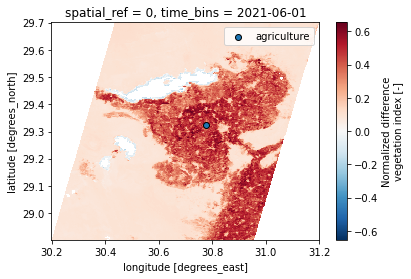

In [7]:
%matplotlib inline
qm = ds.ndvi.isel(time_bins = 0).plot()
fig = qm.get_figure()
for poi, (lat, lon) in diagnostics.items():
    fig.gca().scatter(lon, lat, label = poi, edgecolors = "black")
fig.gca().legend()

Now we run `pre_et_look` with `diagnostics` as an keyword argument. This will run the function for only the pixel(s) we've selected (i.e. it will be a lot faster than running the entire domain). It will also create a folder called `GRAPHS` in our `project_folder`, containing the graphs it creates.

> PRE_ET_LOOK
    --> Example dataset is MODIS.MOD13Q1.061.
    --> Collecting `ndvi` from MODIS.MOD13Q1.061.
    --> Collecting `ndvi` from MODIS.MYD13Q1.061.
    > DIAGNOSTICS
        --> Using `reproject_chunk` on MOD13Q1.061.nc:ndvi (nearest).
        --> Using `reproject_chunk` on MYD13Q1.061.nc:ndvi (nearest).
        --> Compositing `ndvi` (mean) (diagnostic).
        --> Creating graph for `ndvi`.
    < DIAGNOSTICS (0:00:07.180040)
< PRE_ET_LOOK (0:00:07.270527)


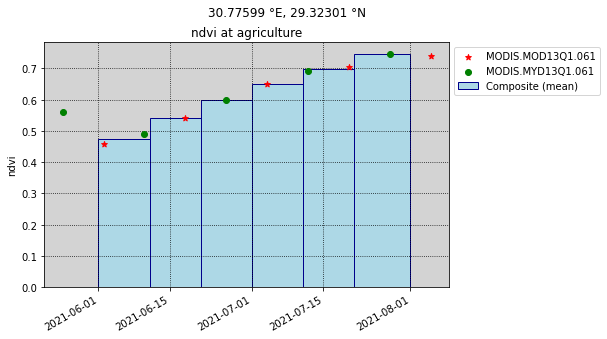

In [9]:
pywapor.pre_et_look.main(project_folder, latlim, lonlim, timelim, bin_length = bin_length,
                            sources = sources, diagnostics = diagnostics)

In the graph we have just created, you should see a couple of things. First of all, there are red-stars and green-dots that show available NDVI measurements at our POI, coming from MOD13 and MYD13 respectively. Then there are blue bars that show the composite pixel values at this location. Since our composites are dekadal, the width of the bars is about 10 days (check the x-axis).

Each composite value is the mean of the available measurements within the respective time_bin. For example, most of the bars match with some of the red-stars or green-dots. While the first bar, ranging from June 1st till June 11th is exactly in between two measurements, i.e. it's the mean of the two available measurements.

The composite type is defined using the keyword `composite_type` in the `sources` variable. Possible values are `"mean"`, `"min"`, `"max"`.

Now let's adjust our `composite_length` to create 6-day composites (instead of dekadal) and see what happens.

In [10]:
bin_length = 6

bins = pywapor.general.compositer.time_bins(timelim, bin_length)

for i, (start, end) in enumerate(zip(bins[:-1], bins[1:])):
    print(f"Composite {i + 1} starts at {start} and ends at {end}.\n")

Composite 1 starts at 2021-06-01T00:00:00.000000000 and ends at 2021-06-07T00:00:00.000000000.

Composite 2 starts at 2021-06-07T00:00:00.000000000 and ends at 2021-06-13T00:00:00.000000000.

Composite 3 starts at 2021-06-13T00:00:00.000000000 and ends at 2021-06-19T00:00:00.000000000.

Composite 4 starts at 2021-06-19T00:00:00.000000000 and ends at 2021-06-25T00:00:00.000000000.

Composite 5 starts at 2021-06-25T00:00:00.000000000 and ends at 2021-07-01T00:00:00.000000000.

Composite 6 starts at 2021-07-01T00:00:00.000000000 and ends at 2021-07-07T00:00:00.000000000.

Composite 7 starts at 2021-07-07T00:00:00.000000000 and ends at 2021-07-13T00:00:00.000000000.

Composite 8 starts at 2021-07-13T00:00:00.000000000 and ends at 2021-07-19T00:00:00.000000000.

Composite 9 starts at 2021-07-19T00:00:00.000000000 and ends at 2021-07-25T00:00:00.000000000.

Composite 10 starts at 2021-07-25T00:00:00.000000000 and ends at 2021-07-31T00:00:00.000000000.

Composite 11 starts at 2021-07-31T00:00

> PRE_ET_LOOK
    --> Example dataset is MODIS.MOD13Q1.061.
    --> Collecting `ndvi` from MODIS.MOD13Q1.061.
    --> Collecting `ndvi` from MODIS.MYD13Q1.061.
    > DIAGNOSTICS
        --> Using `reproject_chunk` on MOD13Q1.061.nc:ndvi (nearest).
        --> Using `reproject_chunk` on MYD13Q1.061.nc:ndvi (nearest).
        --> Compositing `ndvi` (mean) (diagnostic).
        --> Creating graph for `ndvi`.
    < DIAGNOSTICS (0:00:07.295356)
< PRE_ET_LOOK (0:00:07.342995)


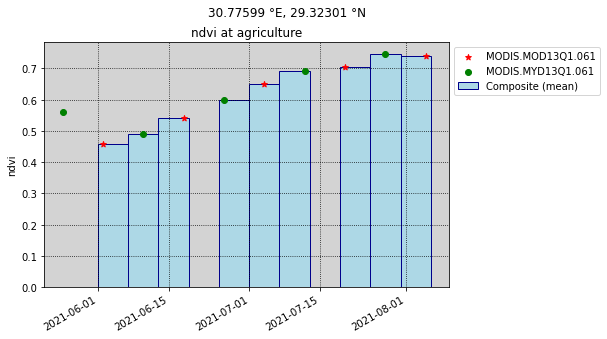

In [11]:
pywapor.pre_et_look.main(project_folder, latlim, lonlim, timelim, bin_length = bin_length,
                            sources = sources, diagnostics = diagnostics)

In the new graph, you'll see that the blue bars have become smaller (i.e. less wide), since our time_bins are now shorter. As a result, some composites could not be created, because no NDVI measurements were available during that respective epoch. For example, the fourth composite (ranging between 2021-06-19 00:00:00 and 2021-06-25 00:00:00) is missing.

We solve this by applying a temporal interpolation between the available measurements. This is especially suitable for this data, because the MOD13 and MYD13 datasets itself are 16-daily composites, i.e. their measurements can be considered valid for a 16-day period.

> PRE_ET_LOOK
    --> Example dataset is MODIS.MOD13Q1.061.
    --> Collecting `ndvi` from MODIS.MOD13Q1.061.
    --> Collecting `ndvi` from MODIS.MYD13Q1.061.
    > DIAGNOSTICS
        --> Using `reproject_chunk` on MOD13Q1.061.nc:ndvi (nearest).
        --> Using `reproject_chunk` on MYD13Q1.061.nc:ndvi (nearest).
        --> Compositing `ndvi` (mean) (diagnostic).
        --> Creating graph for `ndvi`.
    < DIAGNOSTICS (0:00:07.707073)
< PRE_ET_LOOK (0:00:07.749995)


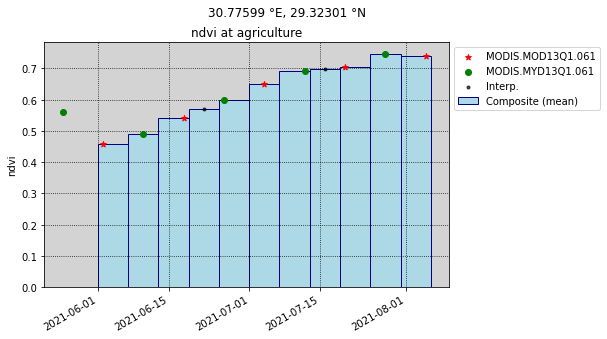

In [12]:
sources["ndvi"]["temporal_interp"] = "linear"

pywapor.pre_et_look.main(project_folder, latlim, lonlim, timelim, bin_length = bin_length,
                            sources = sources, diagnostics = diagnostics)

The two composites that were previously missing are now there! You can see that interpolation points (in black) have appeared in the graph. Note that although here we are looking at one pixel, these interpolations are done for the entire domain.

Possible values for temporal_interp are `False`, `"linear"`, `"nearest"`, `"zero"`, `"slinear"`, `"quadratic"` or `"cubic"`. But be aware that some of these can be computationally heavy, as you can see when combining a cubic `temporal_interp` with a percentile `composite_type`.